# Land Type Classification using Sentinel-2 Satellite Images
***

#### Some tests for GPU `tensorflow`

In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))


2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from tensorflow.python.platform.build_info import build_info

print("CUDA:", build_info["cuda_version"])
print("cuDNN:", build_info["cudnn_version"])

CUDA: 64_112
cuDNN: 64_8


#### Limited VRAM usage as CUDA allocate the whole entirety of VRAM

In [3]:
from tensorflow.config.experimental import list_physical_devices, VirtualDeviceConfiguration, set_virtual_device_configuration #type:ignore
vram_GB = 6
gpus = list_physical_devices('GPU')
if gpus:
    try:
        set_virtual_device_configuration( gpus[0], [VirtualDeviceConfiguration(memory_limit= vram_GB * 1024)] )
        print(f"[/] Limited GPU memory to {vram_GB} GB.")
    except RuntimeError as e:
        print(e)

[/] Limited GPU memory to 6 GB.


#### Install scikit-optimize for Bayesian Optimization

In [4]:
# !pip install scikit-optimize

### Had to re-define `CategoricalFocalLoss` as it was missing in this old version of tensorflow
 - should have the same functionanlity

In [5]:
import tensorflow as tf
from tensorflow.keras.losses import Loss #type:ignore
from tensorflow.keras import backend as K #type:ignore

class CategoricalFocalLoss(Loss):
    """
    Categorical focal loss for one-hot labels.
    Usage:
        loss = CategoricalFocalLoss(gamma=2.0, alpha=0.25)
        model.compile(..., loss=loss, ...)
    """
    def __init__(self, gamma=2.0, alpha=0.25, from_logits=False, reduction=tf.keras.losses.Reduction.AUTO, name="categorical_focal_loss"):
        super().__init__(reduction=reduction, name=name)
        self.gamma = float(gamma)
        self.alpha = float(alpha) if alpha is not None else None
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        """
        y_true: one-hot (batch, classes)
        y_pred: probabilities (softmax) or logits if from_logits=True
        """
        # If logits provided, convert to probabilities
        if self.from_logits:
            y_pred = tf.nn.softmax(y_pred, axis=-1)

        # Clip to avoid log(0) and NaNs
        eps = K.epsilon()
        y_pred = K.clip(y_pred, eps, 1.0 - eps)

        # Compute cross-entropy per class
        cross_entropy = -y_true * K.log(y_pred)  # shape (batch, classes)

        # get p_t: the model probability for the true class per sample (elementwise y_true * y_pred)
        p_t = y_true * y_pred  # (batch, classes)

        # focal weighting: (1 - p_t)^gamma
        focal_factor = K.pow(1.0 - p_t, self.gamma)

        if self.alpha is not None:
            alpha_factor = y_true * self.alpha + (1.0 - y_true) * (1.0 - self.alpha)
            # For multiclass one-hot alpha factor reduces to alpha for true class; keep simple:
            alpha_factor = y_true * self.alpha  # only apply alpha to true class entries
        else:
            alpha_factor = 1.0

        # elementwise focal loss
        loss = alpha_factor * focal_factor * cross_entropy  # (batch, classes)

        # sum over classes then mean over batch
        loss = K.sum(loss, axis=-1)
        return K.mean(loss)

    def get_config(self):
        return {"gamma": self.gamma, "alpha": self.alpha, "from_logits": self.from_logits}


***
# Normal Code

In [6]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import csv

from tensorflow.keras.regularizers import l2 #type:ignore
from tensorflow.keras.optimizers import Adam, RMSprop, SGD #type:ignore
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential #type:ignore
from tensorflow.keras.applications import EfficientNetB3 #type:ignore
from sklearn.utils.class_weight import compute_class_weight
#from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint #type:ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator #type:ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout #type:ignore
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, LeakyReLU, AveragePooling2D #type:ignore
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix

In [7]:
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

In [8]:
from pathlib import Path
import os
import shutil
import random

#### Split data into folders

In [9]:
project_root = Path(os.getcwd()).parent.parent
    
dataset_root = project_root / "Dataset"
original_folder = dataset_root / "EuroSAT_RGB"
base_folder = dataset_root / "EuroSAT_RGB_split"

checkpoints_dir = project_root / "Model_Fine_Tuning" / "Bayesian_Optimization" / "Checkpoints"
results_file = project_root / "Model_Fine_Tuning" / "Bayesian_Optimization" / "bayesian_optimization_results.csv"

os.makedirs(checkpoints_dir, exist_ok=True)

print("Project Root:       ",project_root)
print("Dataset Root:       ",dataset_root)
print("Original Root:      ",original_folder)
print("Base Folder:        ",base_folder)
print("Checkpoints Folder: ",checkpoints_dir)
print("Results File:       ",results_file)

Project Root:        d:\Coding\Jupyter\DEPI\DEPI-Final-Project
Dataset Root:        d:\Coding\Jupyter\DEPI\DEPI-Final-Project\Dataset
Original Root:       d:\Coding\Jupyter\DEPI\DEPI-Final-Project\Dataset\EuroSAT_RGB
Base Folder:         d:\Coding\Jupyter\DEPI\DEPI-Final-Project\Dataset\EuroSAT_RGB_split
Checkpoints Folder:  d:\Coding\Jupyter\DEPI\DEPI-Final-Project\Model_Fine_Tuning\Bayesian_Optimization\Checkpoints
Results File:        d:\Coding\Jupyter\DEPI\DEPI-Final-Project\Model_Fine_Tuning\Bayesian_Optimization\bayesian_optimization_results.csv


In [10]:
def split_data():
    train_ratio = 0.7
    val_ratio = 0.15
    random_state = 42
    random.seed(random_state)

    for split in ["train", "validate", "test"]:
        os.makedirs(os.path.join(base_folder, split), exist_ok=True)
    
    for class_name in os.listdir(original_folder):
        class_path = os.path.join(original_folder, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".png", ".tif"))]
        random.shuffle(images)

        n_total = len(images)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)

        splits = {
            "train": images[:n_train],
            "validate": images[n_train:n_train + n_val],
            "test": images[n_train + n_val:]
        }

        for split_name, split_images in splits.items():
            split_dir = os.path.join(base_folder, split_name, class_name)
            os.makedirs(split_dir, exist_ok=True)

            for img_name in split_images:
                src = os.path.join(class_path, img_name)
                dst = os.path.join(split_dir, img_name)
                shutil.copy(src, dst)

        print(f"{class_name}: {n_total} images split into train/val/test")

In [11]:
#split_data()


#### split_data() Output:
 - AnnualCrop: 3000 images split into train/val/test
 - Forest: 3000 images split into train/val/test
 - HerbaceousVegetation: 3000 images split into train/val/test
 - Highway: 2500 images split into train/val/test
 - Industrial: 2500 images split into train/val/test
 - Pasture: 2000 images split into train/val/test
 - PermanentCrop: 2500 images split into train/val/test
 - Residential: 3000 images split into train/val/test 
 - River: 2500 images split into train/val/test 
 - SeaLake: 3000 images split into train/val/test


In [12]:
train_dir = base_folder / "train"
val_dir = base_folder / "validate"
test_dir = base_folder / "test"

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False 
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False 
)

Found 18900 images belonging to 10 classes.
Found 4050 images belonging to 10 classes.
Found 4050 images belonging to 10 classes.


In [14]:
completed_trials = 0
if os.path.exists(results_file):
    with open(results_file, 'r') as f:
        completed_trials = sum(1 for _ in f) - 1
print(f"Resuming from trial {completed_trials + 1}...")

if not os.path.exists(results_file):
    with open(results_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['trial', 'filters', 'conv_layers', 'dense_units', 'dropout', 'batch_norm', 'optimizer', 'lr', 'accuracy', 'precision', 'recall', 'f1_score', 'weighted_score','flattening_layers'])

Resuming from trial 162...


In [15]:
class_labels = train_generator.classes
class_weight_dict = dict(
    enumerate(
        compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)
    )
)
class_weight_dict

{0: 0.9,
 1: 0.9,
 2: 0.9,
 3: 1.08,
 4: 1.08,
 5: 1.35,
 6: 1.08,
 7: 0.9,
 8: 1.08,
 9: 0.9}

***
#### Defining Space for Bayesian Optimization

In [16]:
space = [
    Categorical([32, 64], name='filters'),
    Integer(2, 4, name='conv_layers'),
    Categorical([128, 256, 512], name='dense_units'),
    Real(0.3, 0.6, name='dropout'),
    Categorical([True, False], name='batch_norm'),
    Categorical(['adam', 'rmsprop', 'sgd'], name='optimizer'),
    Categorical([1e-4, 5e-4, 1e-3, 5e-3], name='lr'),
    Categorical(['flatten', 'GAP2D'], name='flattening_layers')
]

***
### **Objective Function for Bayesian Optimization**
 - Defining **Compile** and **Model structure** (Actuall run is in pre-last cell)
 - This function defines the **objective** used by the Bayesian optimizer (`gp_minimize`) to evaluate different CNN hyperparameter combinations.  
It builds, trains, and validates a Convolutional Neural Network (CNN)


In [17]:
@use_named_args(space)
def objective(**params):
    K.clear_session()
    params['dropout'] = round(params['dropout'], 2)
    print(f"Running with params: {params}")

    model = Sequential()
    filters = params['filters']

    for i in range(params['conv_layers']):
        if i == 0:
            model.add(Conv2D(filters, (3,3), activation='relu', input_shape=(64,64,3)))
        else:
            model.add(Conv2D(filters, (3,3), activation='relu'))
        model.add(MaxPooling2D(2,2))
        if params['batch_norm']:
            model.add(BatchNormalization())
        filters *= 2

    if params["flattening_layers"] == "GAP2D":
        model.add(GlobalAveragePooling2D())
        model.add(Dense(params['dense_units'], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    else:
        model.add(Flatten())
        model.add(Dense(params['dense_units'], activation='relu'))
    
    model.add(Dropout(params['dropout']))
    model.add(Dense(train_generator.num_classes, activation='softmax'))

    if params['optimizer'] == 'adam':
        opt = Adam(learning_rate=params['lr'])
    elif params['optimizer'] == 'rmsprop':
        opt = RMSprop(learning_rate=params['lr'])
    else:
        opt = SGD(learning_rate=params['lr'], momentum=0.9)

    model.compile(optimizer=opt, loss=CategoricalFocalLoss(gamma=2.0, alpha=0.25), metrics=['accuracy'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6) #type: ignore
    ]

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=0 #type: ignore
    )

    val_generator.reset()
    preds = model.predict(val_generator, verbose=0) #type: ignore
    y_true = val_generator.classes
    y_pred = np.argmax(preds, axis=1)

    acc = np.mean(y_true == y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    weighted_score = acc * precision * recall * f1

    with open(results_file, 'r') as f_check:
        trial_num = sum(1 for _ in f_check)

    with open(results_file, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            trial_num,  
            params['filters'], params['conv_layers'], params['dense_units'], params['dropout'],
            params['batch_norm'], params['optimizer'], params['lr'],
            round(acc,6), round(precision,6), round(recall,6) , round(f1,6) , round(weighted_score,6) , params['flattening_layers'] #type:ignore
        ])

    print(f"Trial result: acc={acc:.4f}, f1={f1:.4f}, weighted={weighted_score:.6f}")
    return -weighted_score


***
#### print used VRAM

In [18]:
gpus = tf.config.list_physical_devices('GPU')
details = tf.config.experimental.get_memory_info(gpus[0].name[17:])
print(f"GPU: {gpus[0].name}")
print(f"  Used VRAM: {details['current'] / 1024**2:.2f} MB")
print(f"  Peak VRAM: {details['peak'] / 1024**2:.2f} MB")

GPU: /physical_device:GPU:0
  Used VRAM: 0.00 MB
  Peak VRAM: 0.00 MB


***
#### **Load old results**

In [19]:
import pandas as pd
df = pd.read_csv(results_file)

X_old = df[['filters','conv_layers','dense_units','dropout','batch_norm','optimizer','lr','flattening_layers']].values.tolist()
y_old = [-v for v in df['weighted_score'].values.tolist()]  # negative because we minimize

In [20]:
df_sorted = df.sort_values(by='weighted_score', ascending=False)
df_sorted.reset_index(drop=True, inplace=True)
df_sorted

,trial,filters,conv_layers,dense_units,dropout,batch_norm,optimizer,lr,accuracy,precision,recall,f1_score,weighted_score,flattening_layers
0,147,64,3,128,0.32,True,adam,0.0010,0.960247,0.960594,0.960247,0.960196,0.850483,GAP2D
1,137,64,3,128,0.46,True,rmsprop,0.0005,0.952840,0.952929,0.952840,0.952639,0.824192,GAP2D
2,126,32,3,128,0.33,True,adam,0.0010,0.945926,0.946351,0.945926,0.945805,0.800881,GAP2D
3,142,64,3,256,0.59,True,rmsprop,0.0001,0.944444,0.944842,0.944444,0.944300,0.795833,GAP2D
4,79,64,3,256,0.56,True,rmsprop,0.0005,0.943951,0.945732,0.943951,0.943971,0.795472,GAP2D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,50,32,3,512,0.52,True,adam,0.0050,0.217284,0.066192,0.217284,0.099410,0.000311,flatten
157,33,32,2,256,0.52,True,adam,0.0050,0.185679,0.055198,0.185679,0.080039,0.000152,flatten
158,76,64,2,512,0.54,False,rmsprop,0.0050,0.111111,0.012346,0.111111,0.022222,0.000003,flatten
159,69,32,4,128,0.41,False,adam,0.0050,0.111111,0.012346,0.111111,0.022222,0.000003,flatten


***
### **Start Bayesian Optimization**

In [21]:
res = gp_minimize(
    func=objective,
    dimensions=space,
    n_calls=30,           # number of new evaluations
    x0=X_old,             # previous hyperparameter values
    y0=y_old,             # previous results
    random_state=42
)

Running with params: {'filters': 64, 'conv_layers': 2, 'dense_units': 512, 'dropout': 0.48, 'batch_norm': True, 'optimizer': 'adam', 'lr': 0.0005, 'flattening_layers': 'flatten'}
Trial result: acc=0.8462, f1=0.8438, weighted=0.510577
Running with params: {'filters': 32, 'conv_layers': 3, 'dense_units': 128, 'dropout': 0.52, 'batch_norm': False, 'optimizer': 'adam', 'lr': 0.005, 'flattening_layers': 'GAP2D'}
Trial result: acc=0.8499, f1=0.8491, weighted=0.520758
Running with params: {'filters': 64, 'conv_layers': 2, 'dense_units': 128, 'dropout': 0.46, 'batch_norm': True, 'optimizer': 'adam', 'lr': 0.005, 'flattening_layers': 'flatten'}
Trial result: acc=0.2200, f1=0.0900, weighted=0.000255
Running with params: {'filters': 32, 'conv_layers': 3, 'dense_units': 256, 'dropout': 0.59, 'batch_norm': True, 'optimizer': 'sgd', 'lr': 0.001, 'flattening_layers': 'flatten'}
Trial result: acc=0.7020, f1=0.7047, weighted=0.261225
Running with params: {'filters': 32, 'conv_layers': 4, 'dense_units':

c:\Users\S1NdBAD\anaconda3\envs\tf_gpu\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [64, 4, 128, 0.3, True, 'adam', 0.001, 'GAP2D'] before, using random point [64, 4, 256, 0.39688553150691386, False, 'adam', 0.005, 'flatten']
  warnings.warn(


Running with params: {'filters': 64, 'conv_layers': 4, 'dense_units': 256, 'dropout': 0.4, 'batch_norm': False, 'optimizer': 'adam', 'lr': 0.005, 'flattening_layers': 'flatten'}
Trial result: acc=0.7953, f1=0.7930, weighted=0.398621
Running with params: {'filters': 64, 'conv_layers': 4, 'dense_units': 512, 'dropout': 0.3, 'batch_norm': True, 'optimizer': 'adam', 'lr': 0.001, 'flattening_layers': 'GAP2D'}
Trial result: acc=0.9331, f1=0.9330, weighted=0.759430
Running with params: {'filters': 64, 'conv_layers': 4, 'dense_units': 128, 'dropout': 0.3, 'batch_norm': True, 'optimizer': 'rmsprop', 'lr': 0.001, 'flattening_layers': 'GAP2D'}
Trial result: acc=0.9430, f1=0.9428, weighted=0.790884
Running with params: {'filters': 64, 'conv_layers': 4, 'dense_units': 128, 'dropout': 0.3, 'batch_norm': True, 'optimizer': 'rmsprop', 'lr': 0.0005, 'flattening_layers': 'GAP2D'}
Trial result: acc=0.9494, f1=0.9492, weighted=0.812806
Running with params: {'filters': 64, 'conv_layers': 4, 'dense_units': 

In [22]:
print("Best parameters found:")
print(res.x) #type:ignore
print("Best score:", -res.fun) #type:ignore

Best parameters found:
[64, 3, 128, 0.32, True, 'adam', 0.001, 'GAP2D']
Best score: 0.850483


***
### **Plot Results**
 - First 160 results was randomSearch
 - The rest is Bayesian

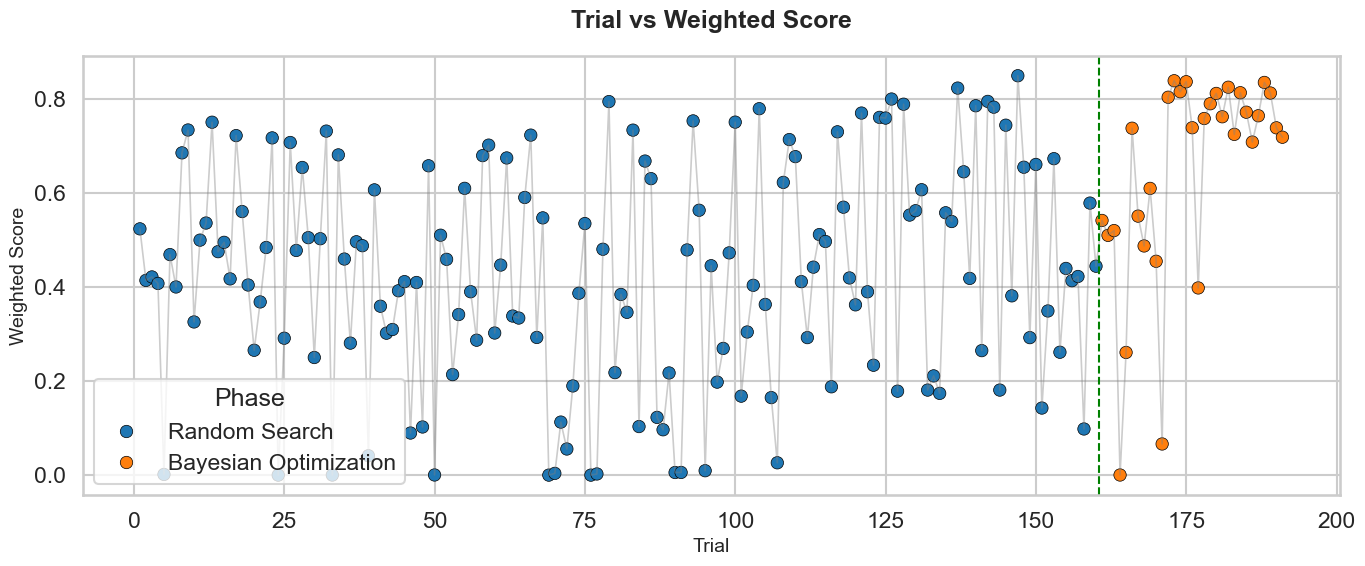

In [23]:
df = pd.read_csv(results_file)

df["phase"] = ["Random Search" if t <= 160 else "Bayesian Optimization" for t in df["trial"]]

sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(14, 6))
sns.scatterplot(
    data=df,
    x="trial",
    y="weighted_score",
    hue="phase",
    palette={"Random Search": "#1f77b4", "Bayesian Optimization": "#ff7f0e"},
    s=80,
    edgecolor="black",
    linewidth=0.5
)

sns.lineplot(data=df, x="trial", y="weighted_score", color="gray", alpha=0.4, linewidth=1.2)

plt.axvline(x=160.5, color="green", linestyle="--", linewidth=1.5)

plt.title("Trial vs Weighted Score", fontsize=18, weight="bold", pad=20)
plt.xlabel("Trial", fontsize=14)
plt.ylabel("Weighted Score", fontsize=14)
plt.legend(title="Phase", loc="best")
plt.tight_layout()
plt.show()

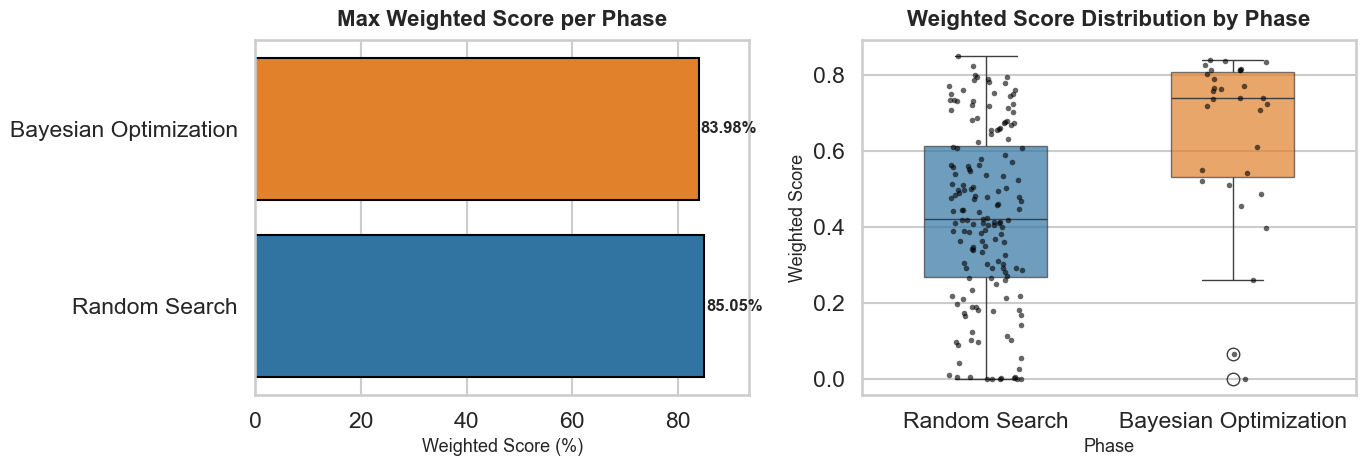

In [29]:
palette = {"Random Search": "#1f77b4", "Bayesian Optimization": "#ff7f0e"}

phase_max = df.groupby("phase")["weighted_score"].max().reset_index()
phase_max["weighted_score_pct"] = phase_max["weighted_score"] * 100

sns.set_theme(style="whitegrid", context="talk")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(
    data=phase_max,
    y="phase",
    x="weighted_score_pct",
    hue="phase",
    palette=palette,
    legend=False,
    edgecolor="black",
    ax=axes[0]
)

for i, row in phase_max.iterrows():
    axes[0].text(
        row["weighted_score_pct"] + 0.3,
        i,
        f"{row['weighted_score_pct']:.2f}%",
        va="center",
        fontsize=12,
        weight="bold"
    )

axes[0].set_title("Max Weighted Score per Phase", fontsize=16, weight="bold", pad=10)
axes[0].set_xlabel("Weighted Score (%)", fontsize=13)
axes[0].set_ylabel("")
axes[0].set_xlim(0, phase_max["weighted_score_pct"].max() * 1.1)

sns.boxplot(
    data=df,
    x="phase",
    y="weighted_score",
    hue="phase",
    palette=palette,
    legend=False,
    width=0.5,
    boxprops=dict(alpha=0.7),
    ax=axes[1]
)
sns.stripplot(
    data=df,
    x="phase",
    y="weighted_score",
    color="black",
    size=4,
    alpha=0.6,
    jitter=0.15,
    ax=axes[1]
)

axes[1].set_title("Weighted Score Distribution by Phase", fontsize=16, weight="bold", pad=10)
axes[1].set_xlabel("Phase", fontsize=13)
axes[1].set_ylabel("Weighted Score", fontsize=13)

plt.tight_layout()
plt.show()